## 1. importing packages

In [31]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Activation, concatenate
from tensorflow.keras.callbacks import History
from tensorflow.keras import optimizers


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3490,2023-01-25 00:00:00-03:00,109.000000,110.680000,108.209999,110.650002,6427546,0,0
3491,2023-01-26 00:00:00-03:00,110.699997,111.099998,109.860001,110.419998,4382206,0,0
3492,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3493,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0


In [4]:
len(bova11)

3495

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3397,2023-01-25 00:00:00-03:00,109.000000,110.680000,108.209999,110.650002,6427546,0,0
3398,2023-01-26 00:00:00-03:00,110.699997,111.099998,109.860001,110.419998,4382206,0,0
3399,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3400,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3402/3402 [00:00<00:00, 7497.72it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

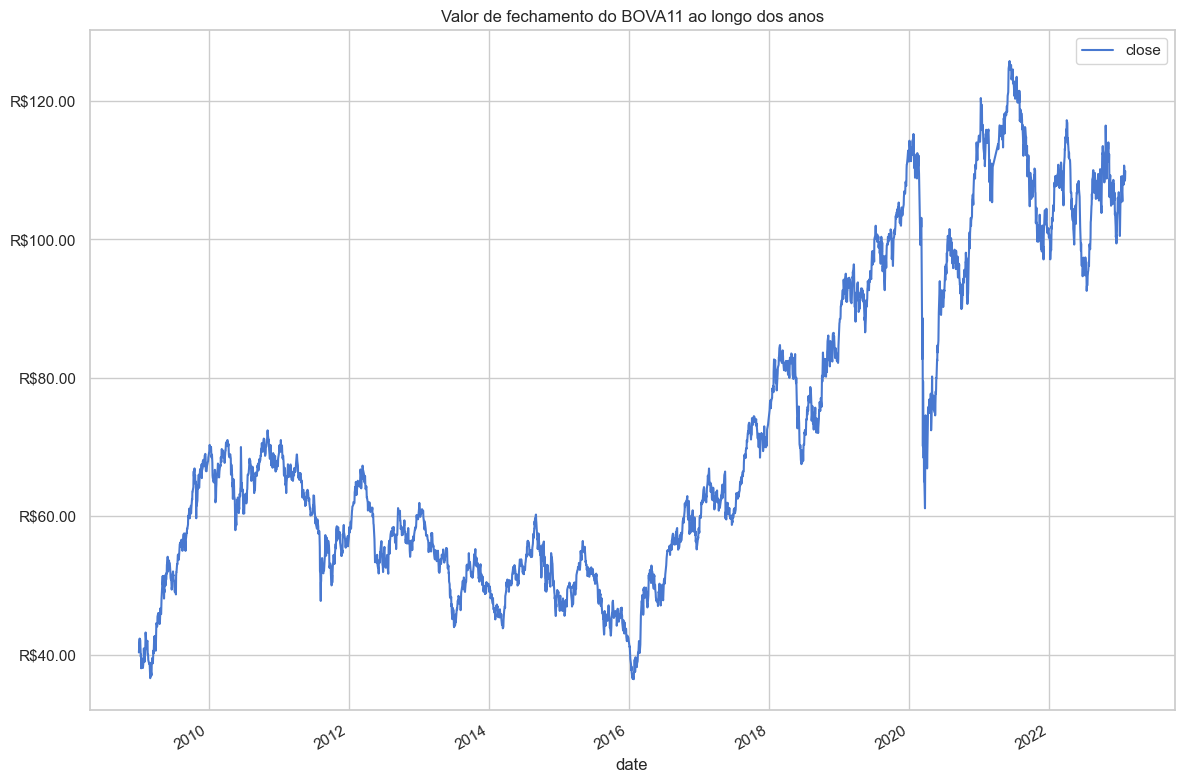

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

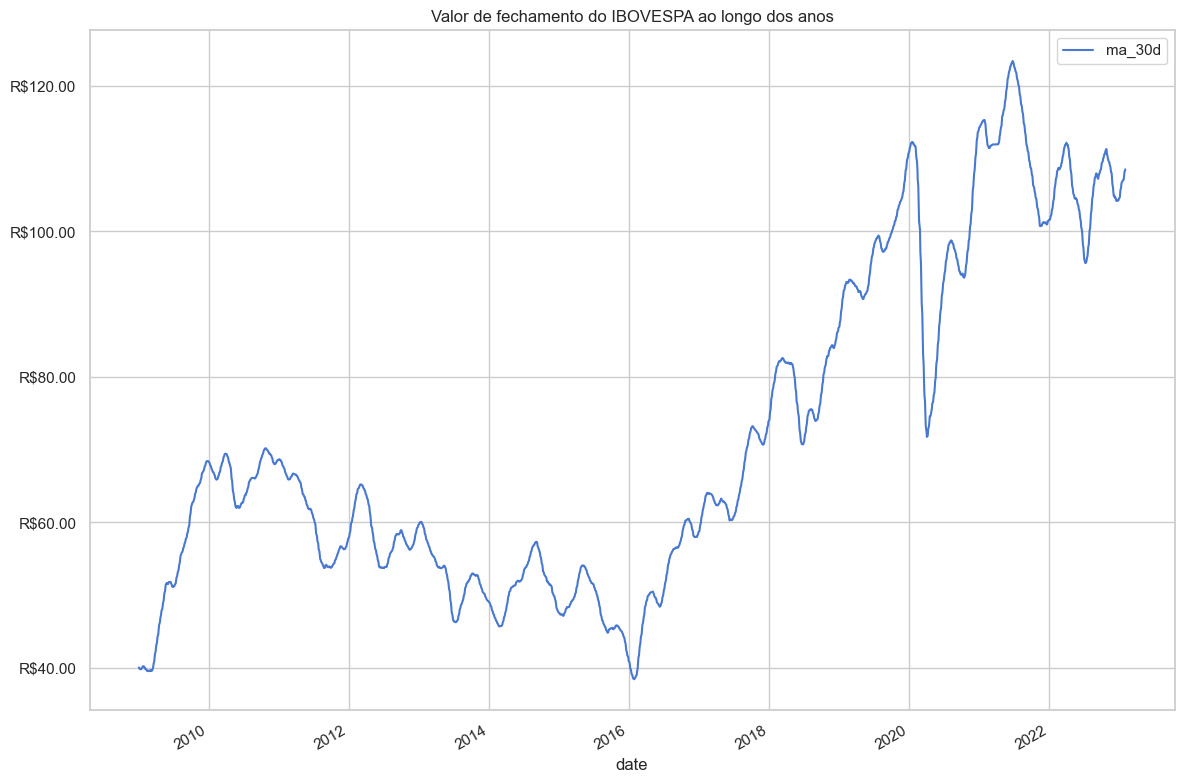

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.123000,107.671500,105.684572,1.061239,2.192330,3.248390,111.463175,108.870158,112.056159,103.286840,112.181351,99.187793,60.925992
3398,110.699997,111.099998,109.860001,110.419998,-0.230003,109.823334,109.211110,107.974210,105.842941,1.041406,1.771676,3.157112,112.299324,107.347344,111.517563,104.430857,112.157166,99.528716,60.155206
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,109.223749,108.180000,105.998788,0.906326,1.572102,3.070380,111.353361,106.993303,111.324204,105.035796,112.139548,99.858028,53.755845
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,109.334285,108.337647,106.170625,1.010257,1.466516,2.953892,110.499468,107.460529,111.270678,105.404616,112.078410,100.262840,54.525609


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,109.000000,110.680000,108.209999,110.650002,1.220001,110.166667,109.123000,107.671500,105.684572,1.061239,...,3.248390,111.463175,108.870158,112.056159,103.286840,112.181351,99.187793,60.925992,1.650002,110.419998
3398,110.699997,111.099998,109.860001,110.419998,-0.230003,109.823334,109.211110,107.974210,105.842941,1.041406,...,3.157112,112.299324,107.347344,111.517563,104.430857,112.157166,99.528716,60.155206,-0.279999,108.400002
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,109.223749,108.180000,105.998788,0.906326,...,3.070380,111.353361,106.993303,111.324204,105.035796,112.139548,99.858028,53.755845,-1.879997,108.699997
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,109.334285,108.337647,106.170625,1.010257,...,2.953892,110.499468,107.460529,111.270678,105.404616,112.078410,100.262840,54.525609,-0.310005,109.839996


In [24]:
bova11.dropna(inplace = True)

In [25]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.76315995  0.6625376   0.66621716 ...  0.35221771 -0.85035523
   0.6114222 ]
 [ 0.75647048  0.64445932  0.63205208 ...  0.16001159 -0.89494206
   0.61814103]
 [ 0.73624277  0.62280992  0.62733194 ...  0.1831316  -0.85119142
   0.64367293]]


Select the features and prediction target columns

In [26]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3286, 100, 19), (3286, 1))

Split the train and test data

In [27]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 4. Creating the model

In [32]:
def create_gru_model(backcandles, num_features):
    gru_input = Input(shape = (backcandles, num_features), name = 'gru_input')
    inputs = GRU(150, name = 'first_layer')(gru_input)
    inputs = Dense(1, name = 'dense_layer')(inputs)
    output = Activation('linear', name = 'output')(inputs)
    model = Model(inputs = gru_input, outputs = output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [33]:
model = create_gru_model(100, 19)
model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 30, shuffle = True, validation_split = 0.1)

Epoch 1/30
178/178 [==============================] - 27s 121ms/step - loss: 0.0135 - val_loss: 0.0019
Epoch 2/30
178/178 [==============================] - 23s 130ms/step - loss: 8.9515e-04 - val_loss: 0.0014
Epoch 3/30
178/178 [==============================] - 25s 138ms/step - loss: 7.9616e-04 - val_loss: 0.0014
Epoch 4/30
178/178 [==============================] - 32s 177ms/step - loss: 8.0604e-04 - val_loss: 0.0019
Epoch 5/30
178/178 [==============================] - 29s 159ms/step - loss: 7.4923e-04 - val_loss: 0.0031
Epoch 6/30
178/178 [==============================] - 25s 142ms/step - loss: 7.0625e-04 - val_loss: 0.0040
Epoch 7/30
178/178 [==============================] - 25s 138ms/step - loss: 6.9232e-04 - val_loss: 0.0018
Epoch 8/30
178/178 [==============================] - 30s 169ms/step - loss: 6.5600e-04 - val_loss: 0.0012
Epoch 9/30
178/178 [==============================] - 38s 215ms/step - loss: 6.4919e-04 - val_loss: 0.0012
Epoch 10/30
178/178 [====================

### 5. Making predictions

In [34]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 5s 76ms/step
[0.5820394] [0.61119819]
[0.5881456] [0.5968645]
[0.5898499] [0.63023511]
[0.5926541] [0.62418815]
[0.60244185] [0.65218367]
[0.5964111] [0.64613655]
[0.5857503] [0.57558797]
[0.53941995] [0.57402023]
[0.5090366] [0.50503922]
[0.48003146] [0.47547596]


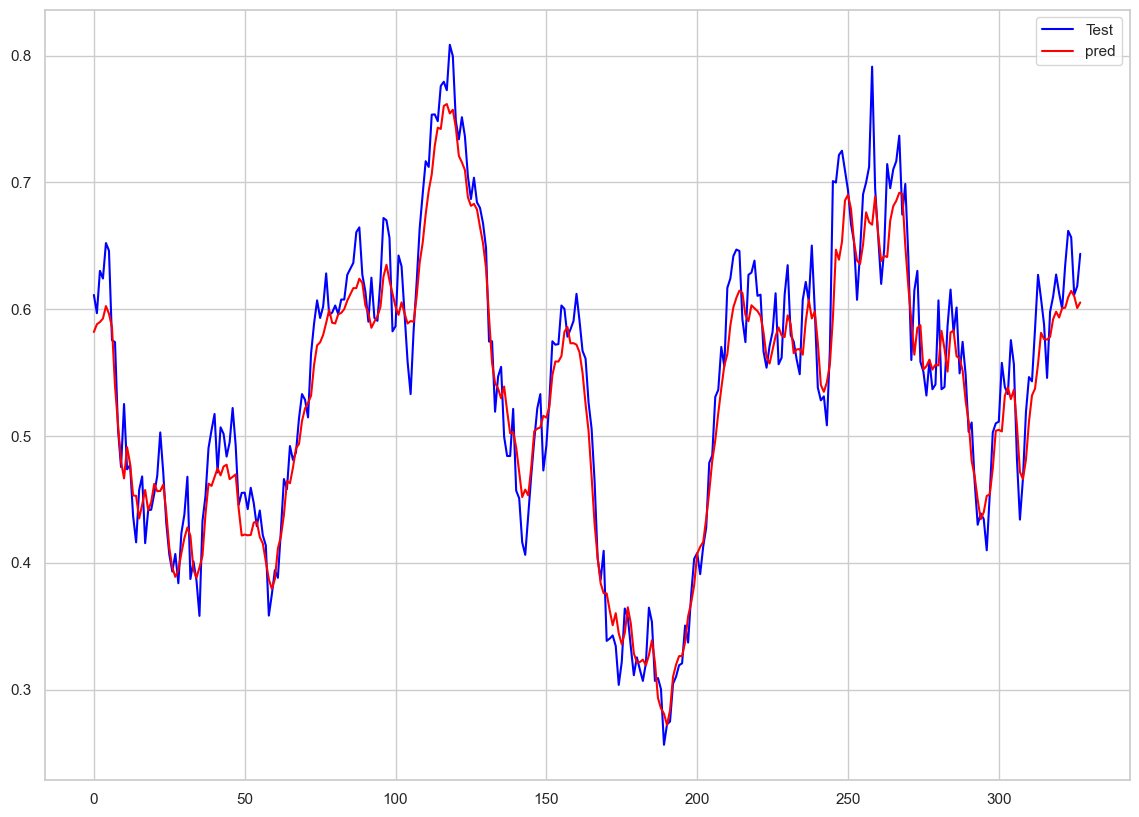

In [35]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [36]:
# removing last prediction, (nan values to calculate the right metrics)
y_test = y_test[:-1]
y_pred = y_pred[:-1]

In [37]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [38]:
MAPE(y_test, y_pred)

4.216393221722756

In [39]:
MAE(y_test, y_pred)

0.022884408686672353

In [40]:
RMSE(y_test, y_pred)

0.028706434334643687

We can cleary see the improvement from the feature engineering made in the second version of the model, reducing every error metric observated.

### Next Steps:
    - test new hyperparametrs (Grid search, Random search, Hill climbing, Bayesian optimization)
    - Run versions to predict diferent targets(target next diference, target next day up/down)